In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
#from epftoolbox.evaluation import MASE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

import pandas_ta as ta

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
print(sys.version)


3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]


In [3]:


def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    
    print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original

In [4]:

# Step 1: Split the data
def split_data(data, max_lag, sma_windows, train_start, train_end, test_start, test_end):
    """
    Splits the dataset into training and testing sets with lagged log returns, SMA, and RSI features.
    """
    # Generate lagged log return features
    for lag in range(1, max_lag + 1):
        data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)

    # Generate SMA features
    for window in sma_windows:
        data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
    
    # Compute RSI directly
    data['RSI_14'] = ta.rsi(data['Log_Return'], length=14)
    
    # Drop rows with NaN values due to lagging, SMA, and RSI calculation
    data = data.dropna()
    
    # Split data into train and test sets based on provided dates
    train_size = int(len(data) * 0.75)
    train_data, test_data = data[:train_size], data[train_size:]
    
    # Extract features (X) and target (y)
    feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                      [f'SMA_{window}' for window in sma_windows] + \
                      ['RSI_14']  # Add RSI feature
    
    X_train = train_data[feature_columns]
    y_train = train_data['Log_Return']
    X_test = test_data[feature_columns]
    y_test = test_data['Log_Return']
    
    return X_train, X_test, y_train, y_test



# Step 2: Scale the data

def scale_data(X_train, X_test, y_train, y_test):
    # Create scalers for features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Scale features
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale target variable
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# Step 3: Model training with hyperparameter tuning
def model_training(X_train_scaled, y_train_scaled):
    """
    Trains a Random Forest model using Bayesian Optimization.
    """

    rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_space = {
        'n_estimators': (50, 180),  # Reduce upper bound from 300+ to 200
        'max_depth': (3, 12),  # Limit tree depth for faster training
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': (0.6, 1.0),
        'max_leaf_nodes': (20, 70) 
    }

    bayes_search = BayesSearchCV(
        estimator=rf_reg,
        search_spaces=param_space,
        n_iter=40,
        cv=5,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1
    )

    bayes_search.fit(X_train_scaled, y_train_scaled.ravel())

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_

    print("Best Model Parameters:")
    print(best_params)

    return best_model, best_params


# Step 4: Main workflow


def train_final_model(data, max_lag, sma_windows,feature_scaler, target_scaler, best_params):
    
    X_full, _, y_full, _ = split_data(data, max_lag,sma_windows, "2000-01-01", "2021-12-31", None, None)
    X_full_scaled = feature_scaler.transform(X_full)
    y_full_scaled = target_scaler.transform(y_full.values.reshape(-1, 1))

    # Create and train the Random Forest regressor with the best hyperparameters.
    final_model = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params)
    final_model.fit(X_full_scaled, y_full_scaled.ravel())

    return final_model

In [5]:
def forecast_future(data, model, scaler, max_lag, sma_windows, start_date="2022-01-01", end_date="2022-12-31"):
    """Forecast future log returns using the trained model with lagged returns, SMA, and RSI features."""
    if model is None:
        raise ValueError("Cannot forecast because the model is not trained.")
    
    lagged_features = data.iloc[-1, :][[f'Lagged_Log_Return_{i}' for i in range(1, max_lag + 1)]].values
    sma_features = data.iloc[-1, :][[f'SMA_{w}' for w in sma_windows]].values
    rsi_feature = data.iloc[-1, :]['RSI_14']
    
    future_dates = pd.date_range(start=start_date, end=end_date, freq="B")  
    future_forecasts = pd.DataFrame(index=future_dates)
    future_forecasts['Forecasted_Log_Return'] = np.nan
    
    for date in future_forecasts.index:
        input_features = np.hstack((lagged_features, sma_features, [rsi_feature]))
        forecasted_scaled = model.predict(input_features.reshape(1, -1))[0]
        forecasted_original = scaler.inverse_transform([[forecasted_scaled]])[0][0]
        future_forecasts.at[date, 'Forecasted_Log_Return'] = forecasted_original
        
        # Update lagged features
        lagged_features = np.roll(lagged_features, -1)
        lagged_features[-1] = forecasted_scaled
        
        # Update SMA values dynamically
        new_sma_values = []
        for window in sma_windows:
            recent_returns = np.concatenate(([forecasted_original], data['Log_Return'].values[-(window - 1):]))
            new_sma_values.append(np.mean(recent_returns))
        sma_features = np.array(new_sma_values)
        
        # Update RSI dynamically
        data['Log_Return'].iloc[-1] = forecasted_original  # Append forecasted return
        data['RSI_14'] = ta.rsi(data['Log_Return'], length=14)
        rsi_feature = data.iloc[-1, :]['RSI_14']
    
    return future_forecasts

In [6]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [7]:
# Step 7: Main Function
def main(data):
    max_lag = 80
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end = "2015-01-01", "2022-01-01"
    sma_windows = [5,10,15]
    # Split Data for Evaluation
    X_train, X_test, y_train, y_test = split_data(data, max_lag,sma_windows, train_start, train_end, test_start, test_end)

    # Scale Data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)

    # Train Model on Train Set (`2000-2014`)
    start_time = time.time()    
    best_model, best_params = model_training(X_train_scaled, y_train)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    
    # Evaluate Train-Test Performance
    train_rmse, train_mae = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse
                },
                "time":computaton_time
                
        }

    #plot_predictions(data, y_train_scaled, y_test_scaled, target_scaler)
    
    # Train Final Model on Full Dataset (`2000-2023`)
    final_model = train_final_model(data, max_lag,sma_windows, feature_scaler, target_scaler, best_params)

    # Forecast Future (`2024`)
    future_predictions = forecast_future(data, final_model, target_scaler, max_lag, sma_windows,start_date="2022-01-01", end_date="2022-12-31" )

    print("Future Predictions:")
    print(future_predictions)

    return final_model, future_predictions, model_metrics

In [8]:
def run_workflow(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        data = yf.download(ticker, start="2000-01-01", end="2021-12-31")
        
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions, model_metrics = main(data)
        
        # Step 6: Group forecasted returns month-wise and week-wise for 2024
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2022)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
    
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']

#tickers = ['SMH', 'SOXX']

#tickers = ['SMH', 'SOXX', 'PSI','XSD', 'IYW', 'XLK', 'VGT',]

# Execute the workflow for multiple tickers
results = run_workflow(tickers)


Processing SMH...


[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 12), ('max_features', 0.6), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 272.06 seconds
Scaled RMSE: 0.9802842531080328, Scaled MAE: 0.6787903325489101
Original RMSE: 0.02187014610987274, Original MAE: 0.015143815381861223
Scaled RMSE: 0.8313355958362727, Scaled MAE: 0.5826000601753305
Original RMSE: 0.01854710089408495, Original MAE: 0.012997809971197136
Train RMSE: 0.0219, Train MAE: 0.0151
Test RMSE: 0.0185, Test MAE: 0.0130
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.029002
2022-01-04               0.029232
2022-01-05               0.029281
2022-01-06               0.029418
2022-01-07               0.029418
2022-01-10               0.029418
2022-01-11               0.029405
2022-01-12               0.029509
2022-01-13               0.029638
2022-01-14               0.030020
2022-01-17               0.030020
2022-01-18       

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 12), ('max_features', 0.6), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 262.86 seconds
Scaled RMSE: 0.9822320965586352, Scaled MAE: 0.7072188821277721
Original RMSE: 0.019601992475412323, Original MAE: 0.014113669523230187
Scaled RMSE: 0.9608568653897498, Scaled MAE: 0.6665712193796787
Original RMSE: 0.019175415984987405, Original MAE: 0.01330248122860734
Train RMSE: 0.0196, Train MAE: 0.0141
Test RMSE: 0.0192, Test MAE: 0.0133
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.029588
2022-01-04               0.029654
2022-01-05               0.029588
2022-01-06               0.029545
2022-01-07               0.029668
2022-01-10               0.029729
2022-01-11               0.029565
2022-01-12               0.029887
2022-01-13               0.031844
2022-01-14               0.031891
2022-01-17               0.031830
2022-01-18      

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 12), ('max_features', 0.6), ('max_leaf_nodes', 70), ('min_samples_leaf', 2), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 223.24 seconds
Scaled RMSE: 0.9842412899700628, Scaled MAE: 0.727608083580407
Original RMSE: 0.017008371054602206, Original MAE: 0.012573571535735913
Scaled RMSE: 1.2561040713168823, Scaled MAE: 0.8911524022019006
Original RMSE: 0.021706348174850367, Original MAE: 0.015399730612105348
Train RMSE: 0.0170, Train MAE: 0.0126
Test RMSE: 0.0217, Test MAE: 0.0154
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.030008
2022-01-04               0.029618
2022-01-05               0.029655
2022-01-06               0.029772
2022-01-07               0.029758
2022-01-10               0.029698
2022-01-11               0.029927
2022-01-12               0.029857
2022-01-13               0.029813
2022-01-14               0.029814
2022-01-17               0.030274
2022-01-18      

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 11), ('max_features', 0.6), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 208.10 seconds
Scaled RMSE: 0.9835656484855207, Scaled MAE: 0.7220935238523984
Original RMSE: 0.017760296702791497, Original MAE: 0.013038880780891403
Scaled RMSE: 1.182411276049559, Scaled MAE: 0.8435963823947091
Original RMSE: 0.02135086266961632, Original MAE: 0.015232864295130115
Train RMSE: 0.0178, Train MAE: 0.0130
Test RMSE: 0.0214, Test MAE: 0.0152
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.028794
2022-01-04               0.028891
2022-01-05               0.028952
2022-01-06               0.028859
2022-01-07               0.028867
2022-01-10               0.028911
2022-01-11               0.028754
2022-01-12               0.028917
2022-01-13               0.029168
2022-01-14               0.029381
2022-01-17               0.029542
2022-01-18       

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 12), ('max_features', 0.7227998293173207), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 299.20 seconds
Scaled RMSE: 0.984412272930219, Scaled MAE: 0.6608463413023546
Original RMSE: 0.017326799121776176, Original MAE: 0.01163166299422834
Scaled RMSE: 0.8543518255612598, Scaled MAE: 0.5589530501192761
Original RMSE: 0.015037584219423935, Original MAE: 0.009838222748983657
Train RMSE: 0.0173, Train MAE: 0.0116
Test RMSE: 0.0150, Test MAE: 0.0098
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.029298
2022-01-04               0.029714
2022-01-05               0.029850
2022-01-06               0.029754
2022-01-07               0.030030
2022-01-10               0.030306
2022-01-11               0.030306
2022-01-12               0.030306
2022-01-13               0.030402
2022-01-14               0.030306
2022-01-17               0.030582
20

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 12), ('max_features', 0.6), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 298.41 seconds
Scaled RMSE: 0.985610355824711, Scaled MAE: 0.6641772760528815
Original RMSE: 0.01618306197727327, Original MAE: 0.010905346071842518
Scaled RMSE: 0.9012225624927169, Scaled MAE: 0.5769018406133025
Original RMSE: 0.014797470925448055, Original MAE: 0.00947234187047087
Train RMSE: 0.0162, Train MAE: 0.0109
Test RMSE: 0.0148, Test MAE: 0.0095
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.027371
2022-01-04               0.027542
2022-01-05               0.027542
2022-01-06               0.027618
2022-01-07               0.027618
2022-01-10               0.027930
2022-01-11               0.027930
2022-01-12               0.027930
2022-01-13               0.027930
2022-01-14               0.027930
2022-01-17               0.028007
2022-01-18        

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 12), ('max_features', 0.6), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 253.62 seconds
Scaled RMSE: 0.9886000752754034, Scaled MAE: 0.6838776339786853
Original RMSE: 0.012657743732949724, Original MAE: 0.00875616748581241
Scaled RMSE: 1.2501644062681119, Scaled MAE: 0.8241983140143911
Original RMSE: 0.016006736267128747, Original MAE: 0.010552792079261287
Train RMSE: 0.0127, Train MAE: 0.0088
Test RMSE: 0.0160, Test MAE: 0.0106
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.019430
2022-01-04               0.019407
2022-01-05               0.019407
2022-01-06               0.019432
2022-01-07               0.019443
2022-01-10               0.019431
2022-01-11               0.019448
2022-01-12               0.019515
2022-01-13               0.019492
2022-01-14               0.019580
2022-01-17               0.019580
2022-01-18      

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 11), ('max_features', 0.6341454990145337), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 302.63 seconds
Scaled RMSE: 0.9845131640180302, Scaled MAE: 0.6565623701873464
Original RMSE: 0.017347794453610312, Original MAE: 0.011569077448899094
Scaled RMSE: 0.7693506589279332, Scaled MAE: 0.49996643232908244
Original RMSE: 0.013556484140202935, Original MAE: 0.008809750055907785
Train RMSE: 0.0173, Train MAE: 0.0116
Test RMSE: 0.0136, Test MAE: 0.0088
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.024388
2022-01-04               0.024388
2022-01-05               0.024454
2022-01-06               0.024454
2022-01-07               0.024454
2022-01-10               0.024593
2022-01-11               0.024593
2022-01-12               0.024593
2022-01-13               0.024593
2022-01-14               0.024593
2022-01-17               0.024593

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 12), ('max_features', 0.6), ('max_leaf_nodes', 70), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 180)])
Computation Time: 268.18 seconds
Scaled RMSE: 0.9865180352910827, Scaled MAE: 0.6834998033040716
Original RMSE: 0.014967260210041236, Original MAE: 0.010369926391204327
Scaled RMSE: 0.9653603959046905, Scaled MAE: 0.6322862577032428
Original RMSE: 0.014646260610644238, Original MAE: 0.00959292441469181
Train RMSE: 0.0150, Train MAE: 0.0104
Test RMSE: 0.0146, Test MAE: 0.0096
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.022303
2022-01-04               0.022303
2022-01-05               0.022611
2022-01-06               0.022611
2022-01-07               0.022716
2022-01-10               0.022716
2022-01-11               0.022709
2022-01-12               0.022709
2022-01-13               0.023817
2022-01-14               0.023817
2022-01-17               0.023987
2022-01-18      

[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('max_depth', 11), ('max_features', 0.7124811518881449), ('max_leaf_nodes', 70), ('min_samples_leaf', 3), ('min_samples_split', 10), ('n_estimators', 177)])
Computation Time: 283.94 seconds
Scaled RMSE: 0.9873261733622238, Scaled MAE: 0.6710688012347038
Original RMSE: 0.014085096467035986, Original MAE: 0.009573400418648974
Scaled RMSE: 1.0661519050160455, Scaled MAE: 0.6934808956493126
Original RMSE: 0.015209616473071967, Original MAE: 0.009893129116595959
Train RMSE: 0.0141, Train MAE: 0.0096
Test RMSE: 0.0152, Test MAE: 0.0099
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.023191
2022-01-04               0.023303
2022-01-05               0.023498
2022-01-06               0.023498
2022-01-07               0.023735
2022-01-10               0.024009
2022-01-11               0.023895
2022-01-12               0.023960
2022-01-13               0.024095
2022-01-14               0.024462
2022-01-17               0.024620


In [9]:
computation_time = []
for ticker in tickers:
    print(results[ticker].get("model_metrics", {}).get("time", {}))
    computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
total_time = sum(computation_time)
avg_time = mean(computation_time)

print(total_time)
print(avg_time)

272.05913972854614
262.8633909225464
223.24033308029175
208.09699892997742
299.20200181007385
298.4127779006958
253.62425780296326
302.6289210319519
268.1835939884186
283.9382929801941
2672.249708175659
267.2249708175659


Overall mean Training MAE: 0.01176755180323544
Overall mean Test MAE: 0.011509204639295131
Overall mean Training RMSE: 0.016880856230536548
Overall mean Test RMSE: 0.017003388035945893
Total time elapsed to run the model: 2672.25 seconds
Average time consumed by model to train on an ETF: 267.22 seconds


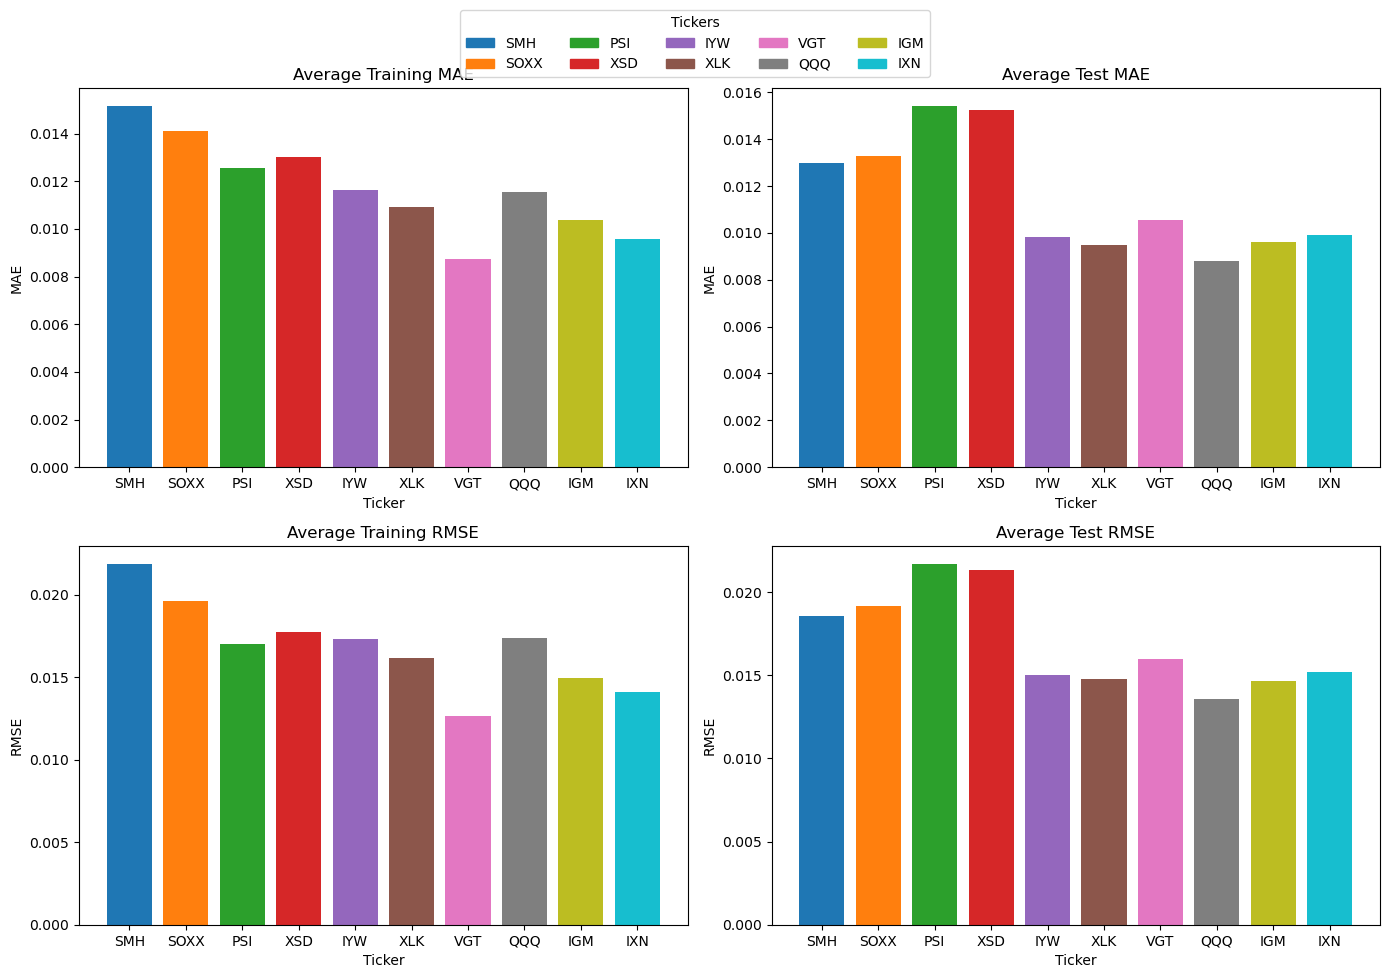

In [10]:
def plot_model_metrics(tickers, results):
    
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))

        computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
    # (Optional) Print some global averages if you want
    print("Overall mean Training MAE:", mean(avg_training_mae))
    print("Overall mean Test MAE:", mean(avg_test_mae))
    print("Overall mean Training RMSE:", mean(avg_training_rmse))
    print("Overall mean Test RMSE:", mean(avg_test_rmse))

    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds" )
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds", )
    # --- 2. Define a color palette for each ticker (must match the number of tickers) ---
    # Example: 10 distinct colors
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    # If you have more than 10 tickers, you need more colors or a different approach.

    # --- 3. Set up a 2×2 subplot grid ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    # Adjust spacing to make room at the top for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))  # Use up to 5 columns or fewer if <5 tickers
    )

    plt.show()
plot_model_metrics(tickers, results)

In [11]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    
    # Check for zero standard deviation to avoid division by zero
    epsilon = 0
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        epsilon = 1e-5 
    
    # Calculate Sharpe ratio
    #sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    sharpe_ratio = (excess_return / (std_return +  epsilon)) # Annualize the Sharpe ratio

    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


"""def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1"""
def calculate_volatility_clustering(returns):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    squared_returns = returns ** 2
    n = len(squared_returns)

    # Mean of squared returns
    mean_squared = np.mean(squared_returns)
    clustering = np.sum((squared_returns - mean_squared) ** 2) / (n - 1 if n > 1 else 1)
    return clustering

def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


In [12]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components with epsilon
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)

    # Composite score calculation
    score = (
        forecasted_mean_normalized
        - (risk_percentage * rachev_normalized)
        + sharpe_normalized
        + sortino_normalized
        - volatility_clustering_normalized
    )

    return score

def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_score_{month}m'] = calculate_composite_score(
                forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores


In [13]:
#tickers = ['SMH', 'SOXX', 'PSI']
#results = run_workflow(tickers)
#risk_metrics_results = compute_risk_metrics(results)
#composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage=0.1)
#composite_scores

In [14]:
#portfolios

In [15]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

'''def portfolio(results, risk_percentage=0.2):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m'
        ) for month in range(1, 13)
    }
    return portfolios'''

'''def portfolio(results, risk_percentage=0.1, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m',
            return_scores=return_scores
        ) for month in range(1, 13)
    }
    return portfolios
'''



"def portfolio(results, risk_percentage=0.1, return_scores=False):\n    risk_metrics_results = compute_risk_metrics(results)\n    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)\n    \n    portfolios = {\n        str(month): select_top_etfs_monthly(\n            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),\n            f'{month}m',\n            return_scores=return_scores\n        ) for month in range(1, 13)\n    }\n    return portfolios\n"

In [16]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, risk_percentage=0.2, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_score_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

def portfolio_optimization(results, risk_percentage=0.2, smoothing=False):
    all_scores = portfolio(results, risk_percentage, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2022-01-01', '2023-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2023-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2023-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [17]:

portfolios, final_value = portfolio_optimization(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.5013749697147478, 'SOXX': 2.5215358830872723, 'PSI': 0.5086834415784012, 'XSD': 0.16041145806968446, 'IYW': 1.3290726276886595, 'XLK': 0.2858797224964347, 'VGT': -1.157464609454159, 'QQQ': -0.3550382029028997, 'IGM': -1.9568503366980932, 'IXN': -1.83760495358063}
Month 2: {'SMH': 0.6429859916102442, 'SOXX': 0.7834855626193843, 'PSI': 2.6845580353065954, 'XSD': 0.47998990994786833, 'IYW': 2.835437787784277, 'XLK': -0.19723620978479844, 'VGT': -2.805920491251208, 'QQQ': -1.3292837146964065, 'IGM': -1.6971983359491485, 'IXN': -1.3968185355867369}
Month 3: {'SMH': 2.7952184343620314, 'SOXX': 1.0906501010675476, 'PSI': -0.03184485921646027, 'XSD': -0.3045196097964168, 'IYW': 4.217319154891742, 'XLK': -0.2657012543844376, 'VGT': -3.372421302884208, 'QQQ': -1.5172172789333518, 'IGM': -1.4905210744176391, 'IXN': -1.1209623106888513}
Month 4: {'SMH': -0.8183888738524809, 'SOXX': 0.8605676111981573, 'PSI': 0.6747442426123252, 'XSD': 0.88806

[*********************100%%**********************]  1 of 1 completed

Buy SOXX: 270.52 shares at 184.37.
Buy IYW: 432.15 shares at 115.41.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['SOXX', 'IYW']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['SOXX', 'IYW']
Updated ticker shares after 2022-02-01 to 2022-02-28: {'SOXX': 270.5206985154089, 'IYW': 432.1549122034611}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['SOXX', 'IYW']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['SOXX', 'IYW']
Updated ticker shares after 2022-03-01 to 2022-03-31: {'SOXX': 270.5206985154089, 'IYW': 432.1549122034611}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['SOXX', 'IYW']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['IYW', 'SOXX']
Updated ticker shares after 2022-04-01 to 2022-04-30: {'SOXX': 270.5206985154089, 'IYW': 432.1549122034611}
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['IYW', 'SOXX']
Top 2 ETFs for 2022-05-01 to 2022-05-31: ['IYW', 'SOXX']
Updated ticker shares after 2022-05-01 to 2022-05-31: {'IYW': 432.1549122034611, 'SOXX': 270.5206985154089}
Top 2 ETFs for 2022-05-01 to 2022-05-31: ['


[*********************100%%**********************]  1 of 1 completed

Final Portfolio Value: 62621.72


In [18]:

portfolios, final_value = portfolio_optimization(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.5013749697147478, 'SOXX': 2.5215358830872723, 'PSI': 0.5086834415784012, 'XSD': 0.16041145806968446, 'IYW': 1.3290726276886595, 'XLK': 0.2858797224964347, 'VGT': -1.157464609454159, 'QQQ': -0.3550382029028997, 'IGM': -1.9568503366980932, 'IXN': -1.83760495358063}
Month 2: {'SMH': 0.6429859916102442, 'SOXX': 0.7834855626193843, 'PSI': 2.6845580353065954, 'XSD': 0.47998990994786833, 'IYW': 2.835437787784277, 'XLK': -0.19723620978479844, 'VGT': -2.805920491251208, 'QQQ': -1.3292837146964065, 'IGM': -1.6971983359491485, 'IXN': -1.3968185355867369}
Month 3: {'SMH': 2.7952184343620314, 'SOXX': 1.0906501010675476, 'PSI': -0.03184485921646027, 'XSD': -0.3045196097964168, 'IYW': 4.217319154891742, 'XLK': -0.2657012543844376, 'VGT': -3.372421302884208, 'QQQ': -1.5172172789333518, 'IGM': -1.4905210744176391, 'IXN': -1.1209623106888513}
Month 4: {'SMH': -0.8183888738524809, 'SOXX': 0.8605676111981573, 'PSI': 0.6747442426123252, 'XSD': 0.88806

[*********************100%%**********************]  1 of 1 completed

Buy SOXX: 270.52 shares at 184.37.
Buy IYW: 432.15 shares at 115.41.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['SOXX', 'IYW']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['IYW', 'PSI']
Sell SOXX: 270.52 shares at 161.15. Total value: 43486.32
Buy PSI: 984.21 shares at 44.07.
Updated ticker shares after 2022-02-01 to 2022-02-28: {'IYW': 432.1549122034611, 'PSI': 984.214379349422}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['IYW', 'PSI']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['IYW', 'SMH']
Sell PSI: 984.21 shares at 41.73. Total value: 40971.86
Buy SMH: 314.76 shares at 129.85.
Updated ticker shares after 2022-03-01 to 2022-03-31: {'IYW': 432.1549122034611, 'SMH': 314.755520903908}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['IYW', 'SMH']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['IYW', 'XSD']
Sell SMH: 314.76 shares at 132.71. Total value: 41666.78
Buy XSD: 204.46 shares at 203.28.
Updated ticker shares after 2022-04-01 to 2022-04-30: {'IYW': 432.1549122034611, 'XSD': 204.45992018670267}
To


[*********************100%%**********************]  1 of 1 completed

Final Portfolio Value: 62235.17


In [19]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 53):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results

def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    # Change range(1, 13) to range(1, 53) and month -> week
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            # Rename risk_metrics_{month}m to risk_metrics_{week}w
            risk_metrics = metrics[f'risk_metrics_{week}w']
            
            # Rename composite_score_{month}m to composite_score_{week}w
            composite_scores.setdefault(ticker, {})[f'composite_score_{week}w'] = calculate_composite_score(
                forecasted_values[ticker],
                risk_percentage,
                risk_metrics['Rachev Ratio'],
                risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'],
                risk_metrics['Volatility Clustering'],
                mean_forecast,
                std_forecast,
                np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores


In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

##############################################
# Assume you already have these functions:
#   - compute_risk_metrics(results)
#   - compute_composite_scores(results, risk_metrics_results, risk_percentage)
#   - select_top_etfs_weekly()  (similar to select_top_etfs_monthly but for weeks)
#   - generate_week_ranges()
#   - gather_etf_data_weekly()
#   - initialize_shares()
#   - manage_portfolio()
##############################################

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, risk_percentage=0.1, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_score_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, risk_percentage=0.1, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, risk_percentage, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2022-01-01', '2022-12-31')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2023-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2023-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [22]:
#results


In [23]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.6592316576976589, 'SOXX': 0.6743366583218925, 'PSI': 0.6883892980443597, 'XSD': 0.28040033446042006, 'IYW': 2.929299943791806, 'XLK': -0.5487142996569259, 'VGT': -0.46932971068406093, 'QQQ': -0.6318113962434712, 'IGM': -2.041984180476694, 'IXN': -1.5398183052619958}
Week 2: {'SMH': -0.07812340857163913, 'SOXX': 3.155919388511492, 'PSI': 0.10667891752940159, 'XSD': -0.24984638190783082, 'IYW': 0.6191819232898443, 'XLK': 1.986428338230319, 'VGT': -2.815981289494881, 'QQQ': 0.7100484690368524, 'IGM': -1.7438198281233266, 'IXN': -1.6904861284997381}
Week 3: {'SMH': 0.6965062405386693, 'SOXX': 2.174895427989812, 'PSI': 1.0248291020166904, 'XSD': 1.9762013591334842, 'IYW': 0.9463146299845678, 'XLK': 0.2923038230111742, 'VGT': -2.26073380870524, 'QQQ': -0.8856642995524753, 'IGM': -2.1294938607692684, 'IXN': -1.835158613646507}
Week 4: {'SMH': 1.1427470144497474, 'SOXX': 1.208498206730169, 'PSI': 0.06957308365126998, 'XSD': -0.177729391061

Buy IYW: 432.15 shares at 115.41.
Buy PSI: 959.44 shares at 51.98.
Top 2 ETFs for 2022-01-01 to 2022-01-07: ['IYW', 'PSI']
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IYW', 'SOXX']
Sell PSI: 959.44 shares at 47.66. Total value: 45615.88
Buy SOXX: 261.79 shares at 173.81.
Updated ticker shares after 2022-01-08 to 2022-01-14: {'IYW': 432.1549122034611, 'SOXX': 261.7907238804005}
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IYW', 'SOXX']
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['IYW', 'SOXX']
Updated ticker shares after 2022-01-15 to 2022-01-21: {'IYW': 432.1549122034611, 'SOXX': 261.7907238804005}
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['IYW', 'SOXX']
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['IYW', 'SOXX']
Updated ticker shares after 2022-01-22 to 2022-01-28: {'IYW': 432.1549122034611, 'SOXX': 261.7907238804005}
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['IYW', 'SOXX']
Top 2 ETFs for 2022-01-29 to 2022-02-04: ['IYW', 'SOXX']
Updated ticker shares after 2022-01-29 to 2022-02-04: {'IYW': 4

In [24]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.6592316576976589, 'SOXX': 0.6743366583218925, 'PSI': 0.6883892980443597, 'XSD': 0.28040033446042006, 'IYW': 2.929299943791806, 'XLK': -0.5487142996569259, 'VGT': -0.46932971068406093, 'QQQ': -0.6318113962434712, 'IGM': -2.041984180476694, 'IXN': -1.5398183052619958}
Week 2: {'SMH': -0.07812340857163913, 'SOXX': 3.155919388511492, 'PSI': 0.10667891752940159, 'XSD': -0.24984638190783082, 'IYW': 0.6191819232898443, 'XLK': 1.986428338230319, 'VGT': -2.815981289494881, 'QQQ': 0.7100484690368524, 'IGM': -1.7438198281233266, 'IXN': -1.6904861284997381}
Week 3: {'SMH': 0.6965062405386693, 'SOXX': 2.174895427989812, 'PSI': 1.0248291020166904, 'XSD': 1.9762013591334842, 'IYW': 0.9463146299845678, 'XLK': 0.2923038230111742, 'VGT': -2.26073380870524, 'QQQ': -0.8856642995524753, 'IGM': -2.1294938607692684, 'IXN': -1.835158613646507}
Week 4: {'SMH': 1.1427470144497474, 'SOXX': 1.208498206730169, 'PSI': 0.06957308365126998, 'XSD': -0.177729391061

Buy IYW: 432.15 shares at 115.41.
Buy PSI: 959.44 shares at 51.98.
Top 2 ETFs for 2022-01-01 to 2022-01-07: ['IYW', 'PSI']
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['SOXX', 'XLK']
Sell IYW: 432.15 shares at 108.83. Total value: 46913.84
Sell PSI: 959.44 shares at 47.66. Total value: 45615.88
Buy XLK: 281.97 shares at 165.96.
Buy SOXX: 261.79 shares at 173.81.
Updated ticker shares after 2022-01-08 to 2022-01-14: {'XLK': 281.9749026283573, 'SOXX': 261.7907238804005}
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['SOXX', 'XLK']
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['SOXX', 'XSD']
Sell XLK: 281.97 shares at 161.78. Total value: 45503.85
Buy XSD: 209.80 shares at 216.35.
Updated ticker shares after 2022-01-15 to 2022-01-21: {'SOXX': 261.7907238804005, 'XSD': 209.7993701749503}
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['SOXX', 'XSD']
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['IYW', 'QQQ']
Sell XSD: 209.80 shares at 202.29. Total value: 42334.21
Sell SOXX: 261.79 shares at 159.35. Total value

Final Portfolio Value: 59303.66
